# Focus stacking with image bunches

Example of focus stacking with automatic alignment and luminosity balance, and partial stacking of image bunches before the final stacking.

In [2]:
from focus_stack import *

In [17]:
def make_job(x):
    job = StackJob("job", "E:/Focus stacking/2024-05-04 - Leaf/"+x, input_path="src")
    job.add_action(AlignLayers("align"))
    job.add_action(BalanceLayersLumi("balance", i_min=30, i_max=65505, mask_size=0))
    job.add_action(FocusStackBunch("bunches", PyramidStack(), input_path="balance", exif_path="src", frames=13, overlap=0, denoise=0))
    job.add_action(FocusStack("stack", PyramidStack(), exif_path="src", postfix='_pyr', denoise=0))
    return job

running align
73 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/A/src'


align:   0%|          | 0/73 [00:00<?, ?it/s]

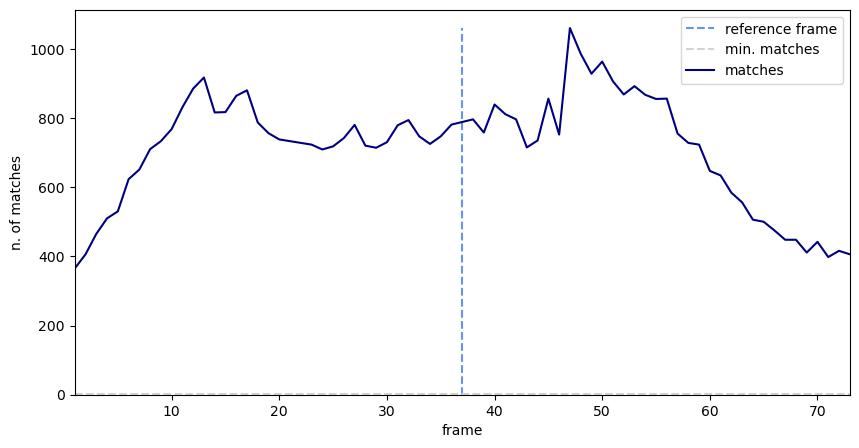

align: elapsed time: 00:12:07.50s                    
align completed                    
running balance
73 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/A/align'


balance:   0%|          | 0/73 [00:00<?, ?it/s]

                                 66.tif                    


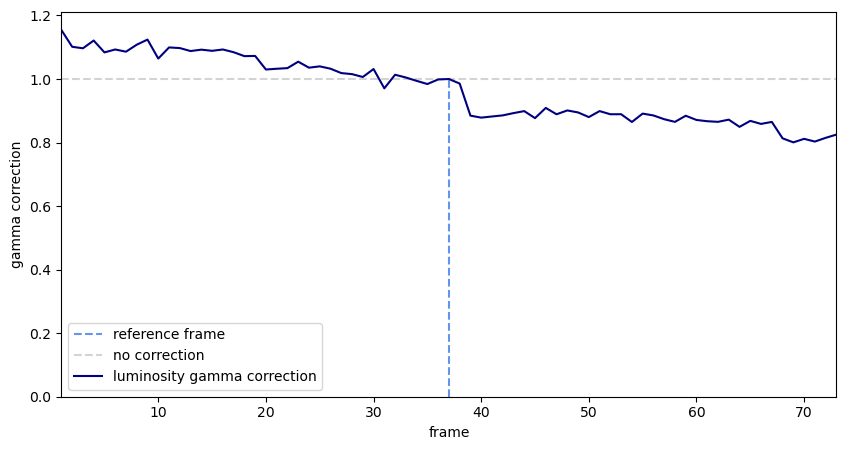

balance: elapsed time: 00:05:13.30s                    
balance completed                    
running bunches


bunches:   0%|          | 0/6 [00:00<?, ?it/s]

bunches: elapsed time: 00:13:23.34s                    
bunches completed                    
running stack
6 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/A/bunches'
stack: elapsed time: 00:00:44.99s                    
stack completed                    
job: elapsed time: 00:31:29.12s                    
job completed                    
running align
73 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/B/src'


align:   0%|          | 0/73 [00:00<?, ?it/s]

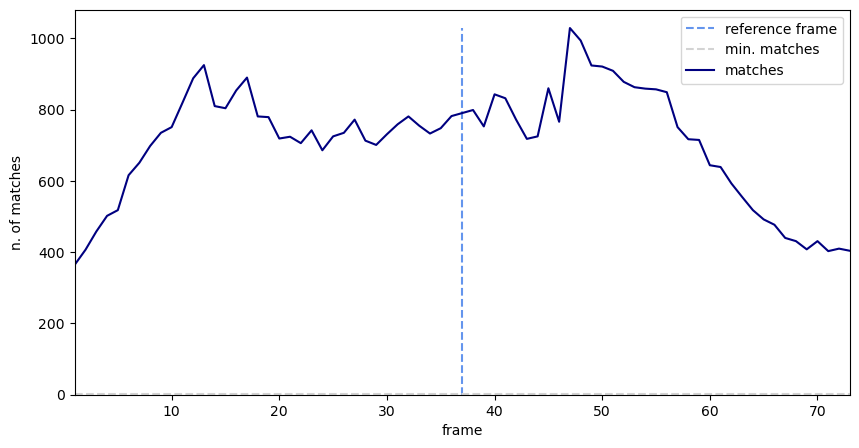

align: elapsed time: 00:12:18.45s                    
align completed                    
running balance
73 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/B/align'


balance:   0%|          | 0/73 [00:00<?, ?it/s]

                                 66.tif                    


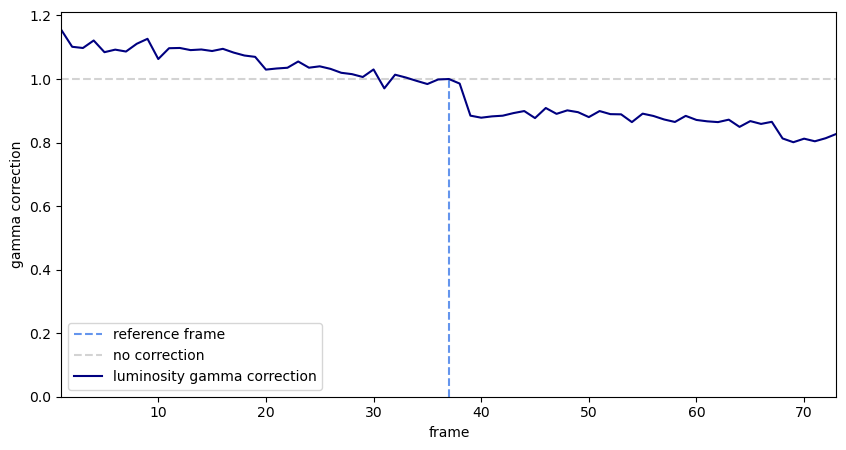

balance: elapsed time: 00:04:45.29s                    
balance completed                    
running bunches


bunches:   0%|          | 0/6 [00:00<?, ?it/s]

bunches: elapsed time: 00:12:53.07s                    
bunches completed                    
running stack
6 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/B/bunches'
stack: elapsed time: 00:00:44.59s                    
stack completed                    
job: elapsed time: 00:30:41.41s                    
job completed                    
running align
89 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/C/src'


align:   0%|          | 0/89 [00:00<?, ?it/s]

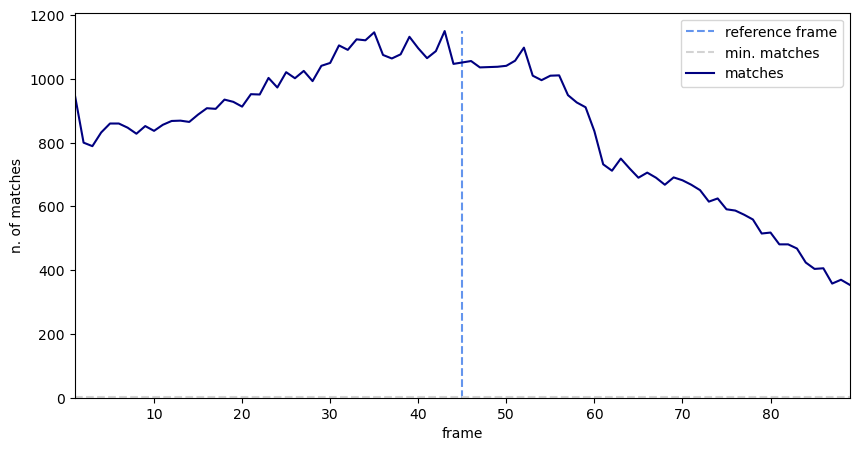

align: elapsed time: 00:15:08.55s                    
align completed                    
running balance
89 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/C/align'


balance:   0%|          | 0/89 [00:00<?, ?it/s]

                                 55.tif                    


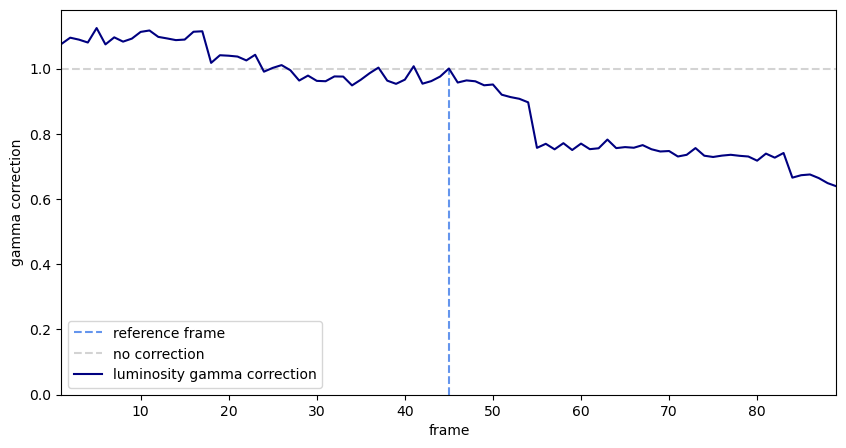

balance: elapsed time: 00:05:36.37s                    
balance completed                    
running bunches


bunches:   0%|          | 0/7 [00:00<?, ?it/s]

bunches: elapsed time: 00:38:07.32s                    
bunches completed                    
running stack
7 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/C/bunches'
stack: elapsed time: 00:00:50.98s                    
stack completed                    
job: elapsed time: 00:59:43.22s                    
job completed                    
running align
93 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/D/src'


align:   0%|          | 0/93 [00:00<?, ?it/s]

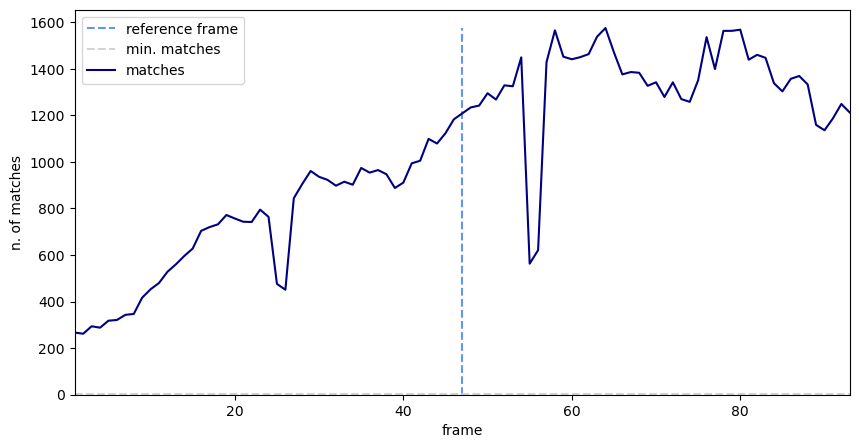

align: elapsed time: 00:16:26.30s                    
align completed                    
running balance
93 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/D/align'


balance:   0%|          | 0/93 [00:00<?, ?it/s]

                                 48.tif                    


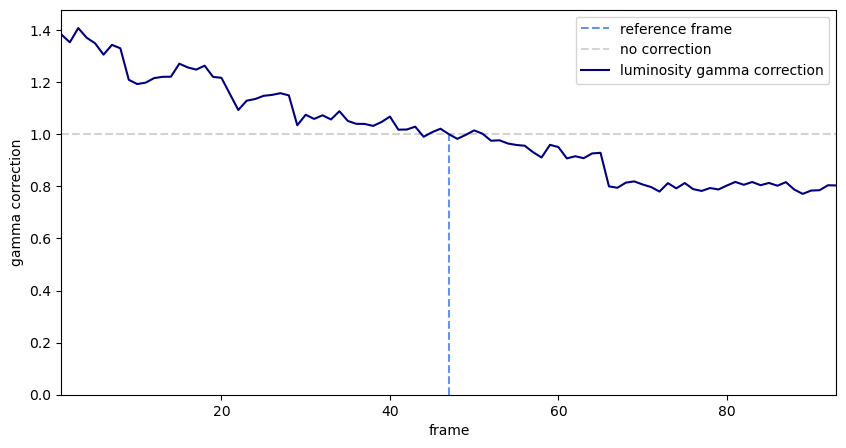

balance: elapsed time: 00:07:07.41s                    
balance completed                    
running bunches


bunches:   0%|          | 0/8 [00:00<?, ?it/s]

bunches: elapsed time: 00:16:22.97s                    
bunches completed                    
running stack
8 files in folder: 'E:/Focus stacking/2024-05-04 - Leaf/D/bunches'


In [ ]:
for x in ['A', 'B', 'C', 'D']:
    make_job(x).run()